Считываю csv файл, данные типа str превращаю в int

In [3]:
import pandas as pd

df = pd.read_csv("./bank-full.csv", sep=";")

X = df.iloc[:,0:16].values #все данные кроме последнего столба
y = df.iloc[:,16].values #данные последнего столба "y"

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
labelencoder_X_1 = LabelEncoder()
X[:, 1] = labelencoder_X_1.fit_transform(X[:, 1]) #превращение типа данных str в int
labelencoder_X_2 = LabelEncoder()
X[:, 2] = labelencoder_X_2.fit_transform(X[:, 2])
labelencoder_X_3 = LabelEncoder()
X[:, 3] = labelencoder_X_3.fit_transform(X[:, 3])
labelencoder_X_4 = LabelEncoder()
X[:, 4] = labelencoder_X_4.fit_transform(X[:, 4])
labelencoder_X_6 = LabelEncoder()
X[:, 6] = labelencoder_X_6.fit_transform(X[:, 6])
labelencoder_X_7 = LabelEncoder()
X[:, 7] = labelencoder_X_7.fit_transform(X[:, 7])
labelencoder_X_8 = LabelEncoder()
X[:, 8] = labelencoder_X_8.fit_transform(X[:, 8])
labelencoder_X_10 = LabelEncoder()
X[:, 10] = labelencoder_X_10.fit_transform(X[:, 10])
labelencoder_X_15 = LabelEncoder()
X[:, 15] = labelencoder_X_15.fit_transform(X[:, 15])

Далее обучаю модель Random Forest

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)#разделяю данные на тренировочные и тестовые


from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

/home/matvey/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Оцениваю качество модели с помощью F1-меры, так как она объединяет способность recall обнаруживать данный класс вообще и способность precision отличать этот класс от других классов. 

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

precision = precision_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
f = (2 * precision * recall) / (precision + recall)

print(f)

0.8889011963544913


С помощью функции SelectKBest нахожу 5 самых значимых переменных

In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

select_k_best_classifier = SelectKBest(score_func=f_classif, k=5).fit(X_train, y_train)
mask = select_k_best_classifier.get_support()
feature_names = ["age","job","marital","education","default","balance","housing","loan","contact","day","month","duration","campaign","pdays","previous","poutcome"]
new_features = []
for bool, feature in zip(mask, feature_names):
    if bool:
        new_features.append(feature)
print(new_features)

['housing', 'contact', 'duration', 'pdays', 'previous']


Для того, чтобы показать как связаны эти 5 переменных с целевой, обрабатываю данные по значимым столбцам

In [8]:
for i in df.columns:#удаляю все столбцы данных, не относящиеся к 5 значимым
    if i in new_features or i == "y":
        continue
    del df[i]

contact = {}#словарь, в форматке {"name_contact": [2, 1]} будут храниться кол-во ответов yes и no, относящиеся к каждому виду contact

duration_b = []#список, который будет содержать значения duration, при овтете yes
duration_r = []#список, который будет содержать значения duration, при овтете no

housing = {}#словарь, в форматке {"name_housing": [2, 1]} будут храниться кол-во ответов yes и no, относящиеся к каждому виду housing

pdays_b = []#список, который будет содержать значения pdays, при овтете yes
pdays_r = []#список, который будет содержать значения pdays, при овтете no

previous_b = []#список, который будет содержать значения previous, при овтете yes
previous_r = []#список, который будет содержать значения previous, при овтете no

for i in df.itertuples():#прохожусь по каждой строке данных
    if i.contact in contact.keys():
        if i.y == "yes":
            contact[i.contact][0] += 1
        elif i.y == "no":
            contact[i.contact][1] += 1
    else:
        if i.y == "yes":
            contact[i.contact] = [1, 0]
        elif i.y == "no":
            contact[i.contact] = [0, 1]
    
    if i.y == "no":
        duration_r.append(i.duration)
        pdays_r.append(i.pdays)
        previous_r.append(i.previous)
    elif i.y == "yes":
        duration_b.append(i.duration)
        pdays_b.append(i.pdays)
        previous_b.append(i.previous)
    
    if i.housing in housing.keys():
        if i.y == "yes":
            housing[i.housing][0] += 1
        elif i.y == "no":
            housing[i.housing][1] += 1
    else:
        if i.y == "yes":
            housing[i.housing] = [1, 0]
        elif i.y == "no":
            housing[i.housing] = [0, 1]

В виде талицы показываю, как взаимосвязана первая значимая переменная с целевой

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


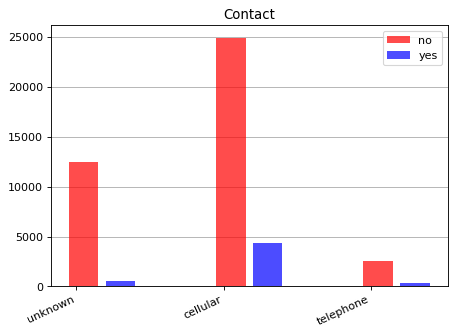

In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt

data_names = contact.keys()
data_values_y = [contact[x][0] for x in contact.keys()]
data_values_n = [contact[x][1] for x in contact.keys()]

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})

plt.title('Contact')

ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)

xs = range(len(data_names))

plt.bar([x + 0.05 for x in xs], data_values_n,
        width = 0.2, color = 'red', alpha = 0.7, label = 'no',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], data_values_y,
        width = 0.2, color = 'blue', alpha = 0.7, label = 'yes',
        zorder = 2)
plt.xticks(xs, data_names)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
plt.show()

В виде графика показываю, как взаимосвязана вторая значимая переменная с целевой

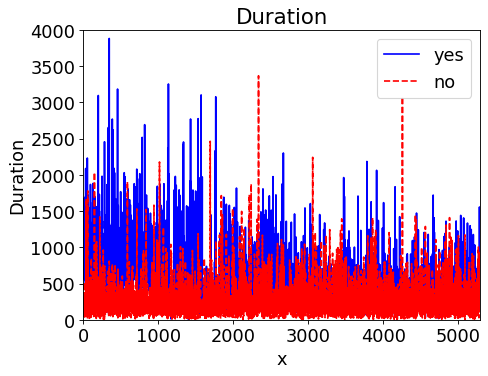

In [10]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 16})

plt.axis([0, min(len(duration_r), len(duration_b)), 0, 4000])

plt.title('Duration')
plt.xlabel('x')
plt.ylabel('Duration')

xs = []
yes = []
no = []

x = 0
while x < min(len(duration_r), len(duration_b)):
    yes += [ duration_b[x]]
    no += [ duration_r[x]]
    xs += [x]
    x += 1

plt.plot(xs, yes, color = 'blue', linestyle = 'solid', label = 'yes')
plt.plot(xs, no, color = 'red', linestyle = 'dashed', label = 'no')
plt.legend(loc = 'upper right')
plt.show()

В виде таблицы показываю, как взаимосвязана третья значимая переменная с целевой

/home/matvey/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


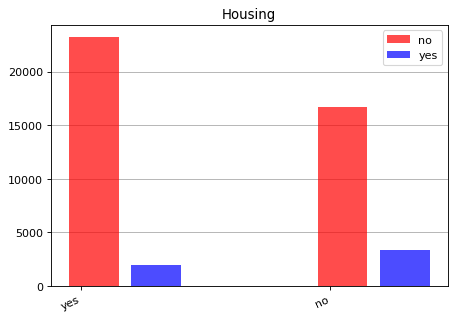

In [11]:
data_names = housing.keys()
data_values_y = [housing[x][0] for x in housing.keys()]
data_values_n = [housing[x][1] for x in housing.keys()]

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})

plt.title('Housing')

ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)

xs = range(len(data_names))

plt.bar([x + 0.05 for x in xs], data_values_n,
        width = 0.2, color = 'red', alpha = 0.7, label = 'no',
        zorder = 2)
plt.bar([x + 0.3 for x in xs], data_values_y,
        width = 0.2, color = 'blue', alpha = 0.7, label = 'yes',
        zorder = 2)
plt.xticks(xs, data_names)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
plt.show()

В виде графика показываю как взаимосвязана четвертая значимая переменная с целевой

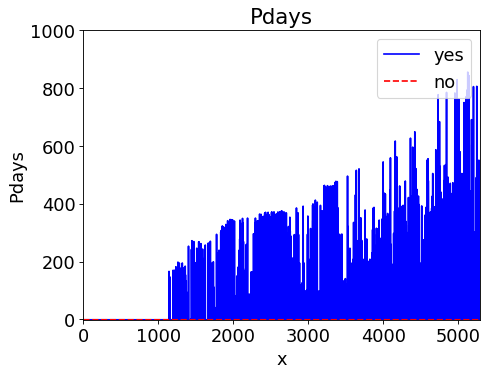

In [12]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 16})

plt.axis([-1, min(len(pdays_r), len(pdays_b)), -1, 1000])

plt.title('Pdays')
plt.xlabel('x')
plt.ylabel('Pdays')

xs = []
yes = []
no = []

x = 0   
while x < min(len(pdays_r), len(pdays_b)):
    yes += [ pdays_b[x]]
    no += [ pdays_r[x]]
    xs += [x]
    x += 1

plt.plot(xs, yes, color = 'blue', linestyle = 'solid', label = 'yes')
plt.plot(xs, no, color = 'red', linestyle = 'dashed', label = 'no')
plt.legend(loc = 'upper right')
plt.show()

В виде графика показываю как взаимосвязана пятая значимая переменная с целевой

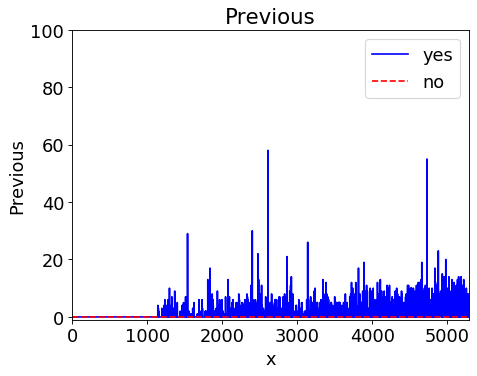

In [13]:
dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 16})

plt.axis([-1, min(len(previous_b), len(previous_r)), -1, 100])

plt.title('Previous')
plt.xlabel('x')
plt.ylabel('Previous')

xs = []
yes = []
no = []

x = 0   
while x < min(len(previous_b), len(previous_r)):
    yes += [ previous_b[x]]
    no += [ previous_r[x]]
    xs += [x]
    x += 1

plt.plot(xs, yes, color = 'blue', linestyle = 'solid', label = 'yes')
plt.plot(xs, no, color = 'red', linestyle = 'dashed', label = 'no')
plt.legend(loc = 'upper right')
plt.show()